<a href="https://colab.research.google.com/github/nroyce7/DSHSRP/blob/main/Solar_Flare_Poisson_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Import

In [ ]:
!pip install xgboost
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 2 Load Data

In [ ]:
# fetch dataset
solar_flare = fetch_ucirepo(id=89)

# data (as pandas dataframes)
X = solar_flare.data.features
y = solar_flare.data.targets

# metadata
print(solar_flare.metadata)

# variable information
print(solar_flare.variables)

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


{'uci_id': 89, 'name': 'Solar Flare', 'repository_url': 'https://archive.ics.uci.edu/dataset/89/solar+flare', 'data_url': 'https://archive.ics.uci.edu/static/public/89/data.csv', 'abstract': 'Each class attribute counts the number of solar flares of a certain class that occur in a 24 hour period', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1389, 'num_features': 10, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['common flares', 'moderate flares', 'severe flares'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5530G', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Notes:\r\n\r\n   -- The database contains 3 potential classes, one for the number of times a certain type of solar flare occured in a 24 hour period.\r\n   -- Each instance represents captur

# 3 Preprocessing Pipeline

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # pass through numeric features
)

# 4 Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5 Build and Train XGBoost Model



In [ ]:
poisson_base = PoissonRegressor(alpha=0.1, max_iter=1000)  # alpha controls regularization
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', MultiOutputRegressor(poisson_base))
])

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['modified Zurich class',
                                                   'largest spot size',
                                                   'spot distribution'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=PoissonRegressor(alpha=0.1,
                                                                 max_iter=1000)))])

# 6 Evaluate Model

In [ ]:
y_pred = model.predict(X_test)

print("Mean Absolute Error:")
print(pd.Series(mean_absolute_error(y_test, y_pred, multioutput='raw_values'), index=y.columns))

print("\nR² Scores:")
print(pd.Series(r2_score(y_test, y_pred, multioutput='raw_values'), index=y.columns))

Mean Absolute Error:
common flares      0.405467
moderate flares    0.115839
severe flares      0.024923
dtype: float64

R² Scores:
common flares      0.050893
moderate flares    0.045795
severe flares     -0.004143
dtype: float64


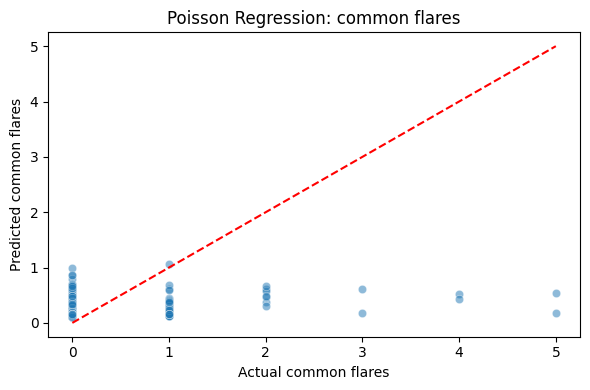

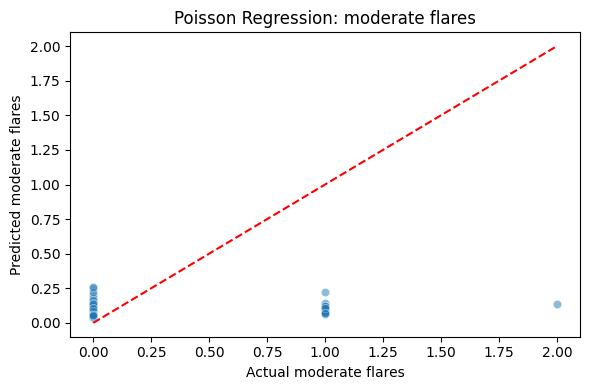

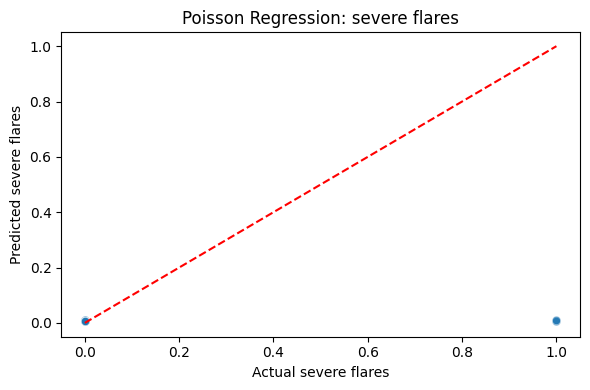

In [ ]:
# Get the list of target columns from the original y
target_cols = y.columns.tolist()

# Loop through each target column for plotting
for i, col in enumerate(target_cols):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x=y_test[col],
        y=y_pred[:, i],  # y_pred is a NumPy array (rows x outputs)
        alpha=0.5
    )
    plt.xlabel(f"Actual {col}")
    plt.ylabel(f"Predicted {col}")
    plt.title(f"Poisson Regression: {col}")

    # Optional: draw 45-degree line for perfect prediction
    max_val = max(y_test[col].max(), y_pred[:, i].max())
    plt.plot([0, max_val], [0, max_val], 'r--')

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PoissonRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

In [ ]:
# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', MultiOutputRegressor(PoissonRegressor(max_iter=1000)))
])

# Define grid of alpha values (regularization strength)
param_grid = {
    'regressor__estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

# Define scoring function (e.g., negative MAE — lower is better)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=scorer,
    verbose=1
)

# Fit
grid_search.fit(X_train, y_train)

# Best alpha
print("Best alpha:", grid_search.best_params_['regressor__estimator__alpha'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best alpha: 0.001


In [ ]:
# Use best estimator to predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate
for i, col in enumerate(y.columns):
    mae = mean_absolute_error(y_test[col], y_pred[:, i])
    r2 = r2_score(y_test[col], y_pred[:, i])
    print(f"{col} MAE: {mae:.4f}")
    print(f"{col} R2: {r2:.4f}")

common flares MAE: 0.4049
common flares R2: -0.0225
moderate flares MAE: 0.1080
moderate flares R2: -0.0558
severe flares MAE: 0.0239
severe flares R2: 0.0920


# TEST

# TEST 2